In [1]:
# Load all the relevant libraries
# Make Sure to mount google drive! and set runtime to have GPU
# Run on a google collab environment

!pip install transformers
!pip install imbalanced-learn
!pip install pandas-summary
!pip install PyDrive
!pip install umap-learn
#Utilities 
import textwrap
import random
from google.colab import files
import io
import time
import datetime
import umap
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns

#Data manipulation
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, classification_report
#ML Stuff
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer
import torch
import imblearn as imb
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_recall_fscore_support, classification_report
import logging
logging.basicConfig(level=logging.ERROR)


     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 10.8MB/s 
     |████████████████████████████████| 3.0MB 19.6MB/s 
     |████████████████████████████████| 890kB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a0cd7f37eb44d6d87cbce5e12520b617cefd8ab8116d9bfd7cd782c39ae6c0a9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Using', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


def pad_and_mask(input_ids_, MAX_LEN = 512):
  attention_masks = []
  input_ids_ = pad_sequences(input_ids_, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

  for sent in input_ids_:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)
  return input_ids_, attention_masks



def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(passed):
    rounded = int(round((passed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=rounded))


def gen_embs(model, df_col,tokenizer, max_len=512, final_layer = 12):
  vectors = []
  model.eval()
  for text in df_col:

    input_ids = [tokenizer.encode(text, add_special_tokens = True, max_length = max_len, truncation=True)]
    temp_input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long",  truncating="post", padding="post")
    input_ids = temp_input_ids[0]
    attn_mask = [int(i>0) for i in input_ids]
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)
    with torch.no_grad():        
        logits, encoded_layers = model(input_ids = input_ids, token_type_ids = None, attention_mask = attn_mask)
    vec = encoded_layers[final_layer][0][0] # layer, batch, token 
    vec = vec.detach().cpu().numpy()
    vectors.append(vec)
  return vectors




Using Tesla V100-SXM2-16GB


In [3]:

class Pipeline():
  def __init__(self, category: str, bert_model: str="allenai/scibert_scivocab_uncased", batch_size=4):
    
    self.test_train_df = ""
    self.validation_df = ""
    self.category = category #labels to be used
    self.BERT_MODEL = bert_model
    self.batch_size=batch_size


  def load_test_train(self, path_to_df):
    self.test_train_df = pd.read_csv(path_to_df)
    self.test_train_df = self.test_train_df[["Abstract.Note", self.category]]
    self.test_train_abstracts = self.test_train_df["Abstract.Note"].values
    self.test_train_labels = self.test_train_df[self.category].values


  def load_cancer_test(self, path_to_df):
    self.cancer_df = pd.read_csv(path_to_df)
    self.cancer_df = self.cancer_df[["Abstract.Note", self.category]]
    self.test_abstracts = self.cancer_df["Abstract.Note"].values
    self.test_labels = self.cancer_df[self.category].values

  
  def process_test_train(self):
    self.tokenizer = BertTokenizer.from_pretrained(self.BERT_MODEL, do_lower_case=True, truncation=True)
    truncation_count = 0
    self.input_ids = []
    self.lengths = []  
    for abstract in self.test_train_abstracts:
      abstract = abstract.lower()
      encoded_sent = self.tokenizer.encode(abstract, add_special_tokens = True,  max_length = 512, truncation=True)
      self.input_ids.append(encoded_sent)
      self.lengths.append(len(encoded_sent))
      if len(encoded_sent) == 512:
        truncation_count+=1

    print("Number of samples", len(self.input_ids))
    print("Min length: ", min(self.lengths))
    print("Max length: ", max(self.lengths))
    print("Media length: ", np.median(self.lengths))
    print("Abstracts probably truncated", truncation_count,"out of",len(self.lengths), "Abstracts")
    #Rip looks like large chunk of abstracts were truncated 
    sns.set(style='darkgrid')
    plt.rcParams["figure.figsize"] = (10,5)
 
    sns.distplot([min(l, 512) for l in self.lengths], kde=False, rug=False)
    plt.title('Abstract Lengths')
    plt.xlabel('Abstract Length')
    plt.ylabel('Abstracts')
    plt.show()
    self.input_ids, self.attention_masks = pad_and_mask(self.input_ids)



  def train_test_split(self, random_state=42, test_size = 0.1):

    self.train_inputs, self.validation_inputs, self.train_labels, self.validation_labels = train_test_split(self.input_ids, self.test_train_labels, 
                                                                random_state=random_state, test_size=test_size)
    self.train_masks, self.validation_masks, _, _ = train_test_split(self.attention_masks,self. test_train_labels,
                                                random_state=random_state, test_size=test_size)


    self.train_inputs = torch.tensor(self.train_inputs)
    self.validation_inputs = torch.tensor(self.validation_inputs)

    self.train_labels = torch.tensor(self.train_labels)
    self.validation_labels = torch.tensor(self.validation_labels)

    self.train_masks = torch.tensor(self.train_masks)
    self.validation_masks = torch.tensor(self.validation_masks)


    self.train_data = TensorDataset(self.train_inputs, self.train_masks, self.train_labels)
    self.train_sampler = RandomSampler(self.train_data)
    self.train_dataloader = DataLoader(self.train_data, sampler=self.train_sampler, batch_size=self.batch_size)

    self.validation_data = TensorDataset(self.validation_inputs, self.validation_masks,self.validation_labels)
    self.validation_sampler = SequentialSampler(self.validation_data)
    self.validation_dataloader = DataLoader(self.validation_data, sampler=self.validation_sampler, batch_size=self.batch_size)


  def process_cancer(self):
    self.test_lengths = []
    self.test_input_ids = []
    self.test_truncation =0
    for abstract in self.test_abstracts:
      abstract = abstract.lower()
      encoded_sent = self.tokenizer.encode(abstract, add_special_tokens = True,  max_length = 512, truncation=True)
      self.test_input_ids.append(encoded_sent)
      self.test_lengths.append(len(encoded_sent))
      if len(encoded_sent) == 512:
        self.test_truncation+=1


    self.test_input_ids, self.test_attention_masks = pad_and_mask(self.test_input_ids)

    self.test_inputs = torch.tensor(self.test_input_ids)
    self.test_masks = torch.tensor(self.test_attention_masks)
    self.test_labels = torch.tensor(self.test_labels)

    self.test_data = TensorDataset(self.test_inputs, self.test_masks, self.test_labels)
    self.test_sampler = SequentialSampler(self.test_data)
    self.test_dataloader = DataLoader(self.test_data, sampler=self.test_sampler, batch_size=self.batch_size)
    print("Number of samples", len(self.test_input_ids))
    print("Min length: ", min(self.test_lengths))
    print("Max length: ", max(self.test_lengths))
    print("Media length: ", np.median(self.test_lengths))
    print("Abstracts probably truncated", self.test_truncation,"out of",len(self.test_lengths), "Abstracts")
    #Rip looks like large chunk of abstracts were truncated 
    sns.set(style='darkgrid')
    plt.rcParams["figure.figsize"] = (10,5)
    test_lengths = [min(l, 512) for l in self.test_lengths]
    sns.distplot(self.test_lengths, kde=False, rug=False)
    plt.title('Abstract Lengths')
    plt.xlabel('Abstract Length')
    plt.ylabel('Abstracts')
    plt.show()


  def train_model(self, seed_val = 42, epochs = 4, ):
    # A special thanks to Chris McCormic at https://mccormickml.com/ for his detailed guides on BERT 
    self.model = BertForSequenceClassification.from_pretrained(self.BERT_MODEL, num_labels = 2, 
        output_attentions = False, 
        output_hidden_states = False,)
    
    optimizer = AdamW(self.model.parameters(),
                      lr = 2e-5, # args.learning_rate - best is 2e-5
                      eps = 1e-4 # args.adam_epsilon  - best is 1e-4.
                  )
    self.model.cuda()

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(self.train_dataloader)*epochs)
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    loss_values = []
    accuracy_values = []
    training_start = time.time()
    for epoch_i in range(0, epochs):
        print("Training - Epoch", epoch_i+1)
        t0 = time.time()
        total_loss = 0
        self.model.train()
        for step, batch in enumerate(self.train_dataloader):
            if step % 50 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('Batch', step,' of',len(self.train_dataloader) , 'time passed', elapsed)
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device, dtype=torch.int64)
            self.model.zero_grad()        

            outputs = self.model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            loss = outputs[0]
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(self.train_dataloader)            
        

        loss_values.append(avg_train_loss)

        print("Average training loss", avg_train_loss)
        print("Training epcoh took", format_time(time.time() - t0))
        print("\n")
        print("Running on validation")
        t0 = time.time()
        self.model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0


        for batch in self.validation_dataloader:

            batch = tuple(t.to(device) for t in batch)
            
            b_input_ids, b_input_mask, b_labels = batch
            

            with torch.no_grad():        

                outputs = self.model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        print("Accuracy", eval_accuracy/nb_eval_steps)
        print("Validation took", format_time(time.time() - t0))


        print("Training took", format_time(time.time()-training_start))



  def save_model(self, path):
    model_to_save = self.model.module if hasattr(self.model, 'module') else self.model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(path)
    self.tokenizer.save_pretrained(path)


  def model_test(self):

    eval_time = time.time()
    self.model.eval()
    self.test_pred = []
    self.test_label = []
    for (step, batch) in enumerate(self.test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = self.model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
      
        self.test_pred.append(logits)
        self.test_label.append(label_ids)


    self.test_pred = np.concatenate(self.test_pred, axis=0)
    self.test_label = np.concatenate(self.test_label, axis=0)
    self.test_pred_rouncded = np.argmax(self.test_pred , axis=1).flatten()

    print("AUC", roc_auc_score(y_true=self.test_label, y_score=self.test_pred[:,1]))
    print("MM Coef", matthews_corrcoef(y_true=self.test_label, y_pred=self.test_pred_rouncded))
    print("accuracy", accuracy_score(y_true=self.test_label, y_pred=self.test_pred_rouncded))
    print(classification_report(y_true=self.test_label, y_pred=self.test_pred_rouncded))
    print("Testing took", format_time(time.time()-eval_time))


  def make_umap(self):
    #For some reason only works on saved models that are loaded from bins   
    combined_text = list(self.test_train_abstracts) + list(self.test_abstracts)
    cancer_labels_shifted = self.cancer_df[self.category]+2
    color_coded_labels = list(self.test_train_labels)+list(cancer_labels_shifted.values)
    cancer_vectors = gen_embs(self.model, combined_text, self.tokenizer)
    reducer = umap.UMAP(random_state=42)
    reducer.fit(cancer_vectors)
    embedding = reducer.transform(cancer_vectors)
    import matplotlib.colors
    cmap = matplotlib.colors.ListedColormap(["red","violet","blue", "green"])
    plt.scatter(embedding[:, 0], embedding[:, 1], c=color_coded_labels, cmap=plt.get_cmap('Dark2', 4), s=.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(5)-.5).set_ticks(np.arange(4))

    plt.title('UMAP projection of '+self.category, fontsize=18);

    #plt.savefig("/content/drive/My Drive/bert_models/"+"scibert_"+lab+".png", bbox_inches='tight', dpi=900)
    plt.show()
  def get_conf_val(self):
    self.pos = []
    self.neg = []
    for i in self.test_pred:
      temp = torch.softmax(torch.tensor(i), dim=0).tolist()
      self.neg.append(temp[0])
      self.pos.append(temp[1])




  def load_model(self, path):
    self.config = BertConfig.from_pretrained(self.BERT_MODEL, num_labels=2, output_hidden_states = True)
    self.model = BertForSequenceClassification.from_pretrained(self.BERT_MODEL, config=self.config)
    self.model.to(device)
    self.model.load_state_dict(torch.load(path, device), strict=False)




Number of samples 8202
Min length:  12
Max length:  512
Media length:  273.0
Abstracts probably truncated 281 out of 8202 Abstracts


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


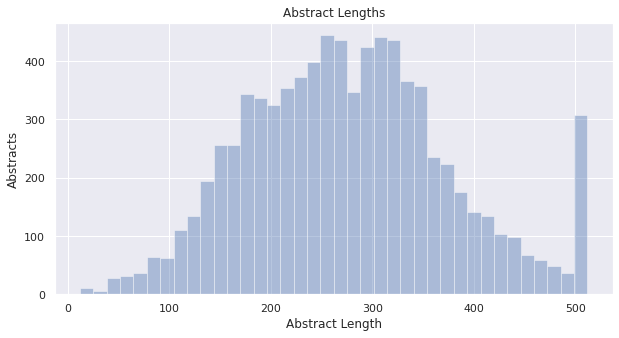

Number of samples 360
Min length:  57
Max length:  512
Media length:  333.0
Abstracts probably truncated 11 out of 360 Abstracts


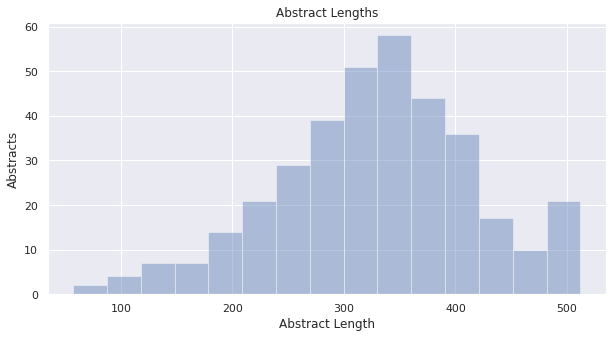

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

AUC 0.7801111111111111
MM Coef 0.5156082864968731
accuracy 0.8805555555555555
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       300
           1       0.72      0.47      0.57        60

    accuracy                           0.88       360
   macro avg       0.81      0.72      0.75       360
weighted avg       0.87      0.88      0.87       360

Testing took 0:00:04


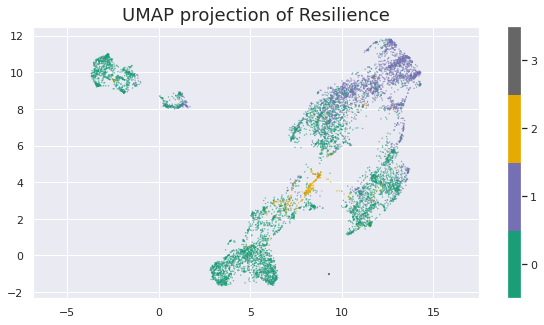

In [5]:

ground_truth_df = pd.read_csv("/content/drive/My Drive/bert_models/complete_n360_methods.csv")
x = Pipeline("Resilience")
x.load_test_train("/content/drive/My Drive/bert_models/ridout_annotated.csv")
#This loads the n360 annotated by undergrads and grad stuents, most of the paper focuses on 
x.load_cancer_test("/content/drive/My Drive/bert_models/KR_annotated_filledin.csv")
x.process_test_train()
x.process_cancer()
x.train_test_split()
#x.train_model()
x.load_model("/content/drive/My Drive/bert_models/bertmodels/model_scibert_Resilience_4.bin")
x.model_test()
x.make_umap()  

Number of samples 8202
Min length:  12
Max length:  512
Media length:  273.0
Abstracts probably truncated 281 out of 8202 Abstracts


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


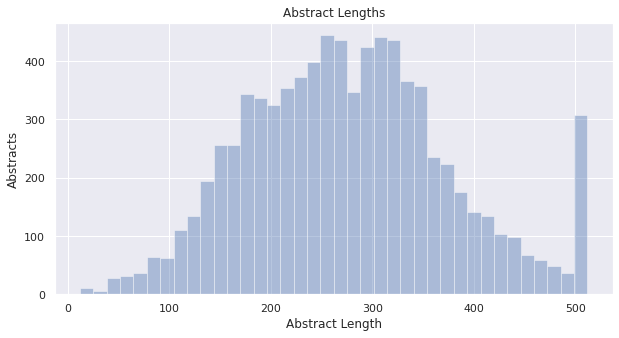

Number of samples 360
Min length:  57
Max length:  512
Media length:  333.0
Abstracts probably truncated 11 out of 360 Abstracts


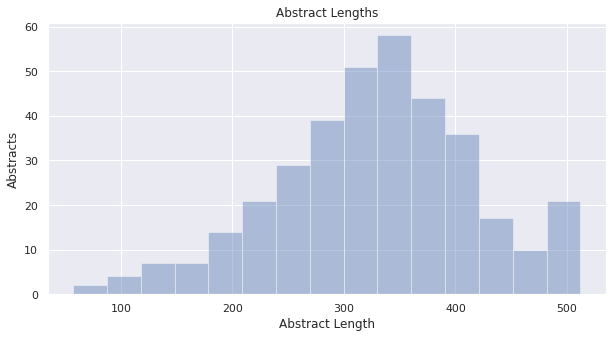

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

AUC 0.7318201376936316
MM Coef 0.2242098251639333
accuracy 0.8055555555555556
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       332
           1       0.20      0.50      0.29        28

    accuracy                           0.81       360
   macro avg       0.58      0.67      0.59       360
weighted avg       0.89      0.81      0.84       360

Testing took 0:00:04


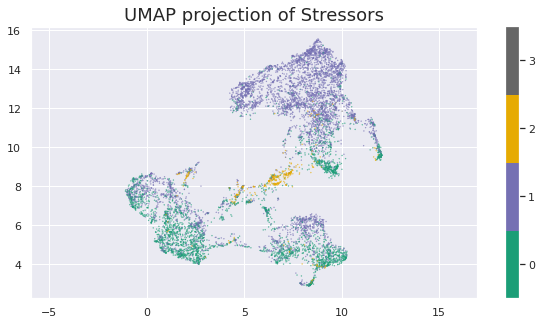

In [6]:
x = Pipeline("Stressors")
x.load_test_train("/content/drive/My Drive/bert_models/ridout_annotated.csv")
x.load_cancer_test("/content/drive/My Drive/bert_models/KR_annotated_filledin.csv")
x.process_test_train()
x.process_cancer()
x.train_test_split()
#x.train_model()
x.load_model("/content/drive/My Drive/bert_models/bertmodels/model_scibert_Stressors_4.bin")
x.model_test()
x.make_umap()  

Number of samples 8202
Min length:  12
Max length:  512
Media length:  273.0
Abstracts probably truncated 281 out of 8202 Abstracts


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


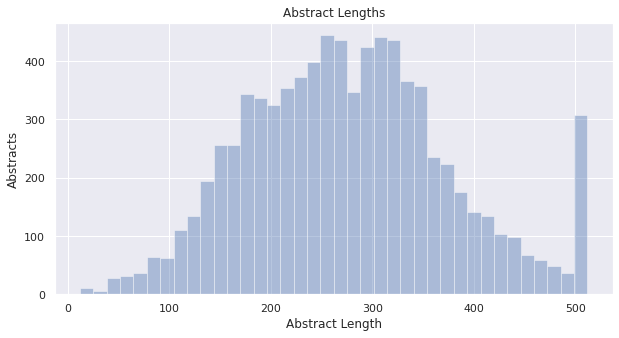

Number of samples 360
Min length:  57
Max length:  512
Media length:  333.0
Abstracts probably truncated 11 out of 360 Abstracts


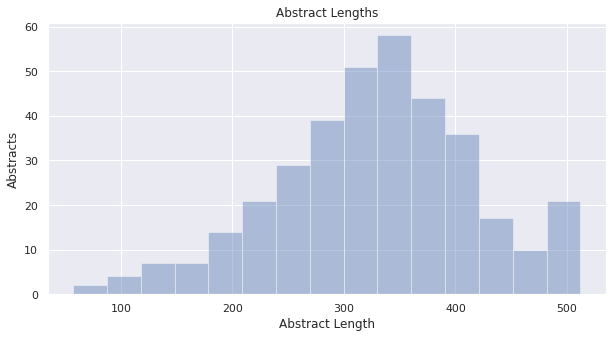

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

AUC 0.8830468749999999
MM Coef 0.48666426339228763
accuracy 0.9166666666666666
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       320
           1       0.78      0.35      0.48        40

    accuracy                           0.92       360
   macro avg       0.85      0.67      0.72       360
weighted avg       0.91      0.92      0.90       360

Testing took 0:00:04


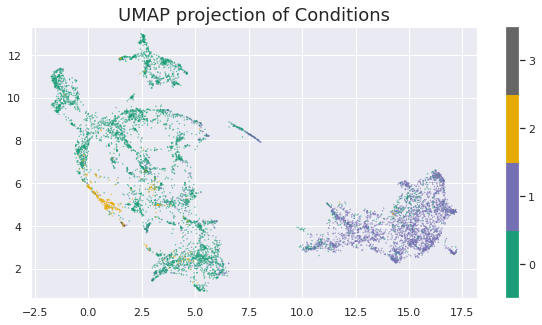

In [7]:
x = Pipeline("Conditions")
x.load_test_train("/content/drive/My Drive/bert_models/ridout_annotated.csv")
x.load_cancer_test("/content/drive/My Drive/bert_models/KR_annotated_filledin.csv")
x.process_test_train()
x.process_cancer()
x.train_test_split()
#x.train_model()
x.load_model("/content/drive/My Drive/bert_models/bertmodels/model_scibert_Conditions_4.bin")
x.model_test()
x.make_umap()

Number of samples 8202
Min length:  12
Max length:  512
Media length:  273.0
Abstracts probably truncated 281 out of 8202 Abstracts


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


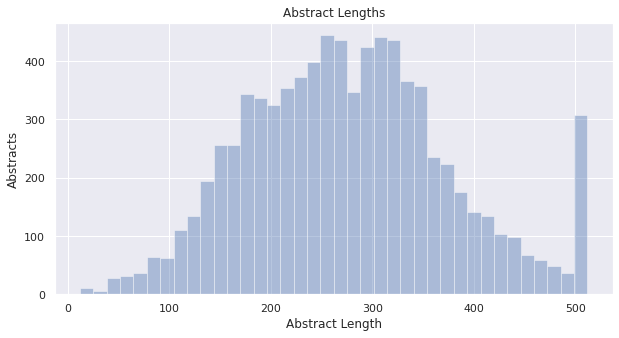

Number of samples 360
Min length:  57
Max length:  512
Media length:  333.0
Abstracts probably truncated 11 out of 360 Abstracts


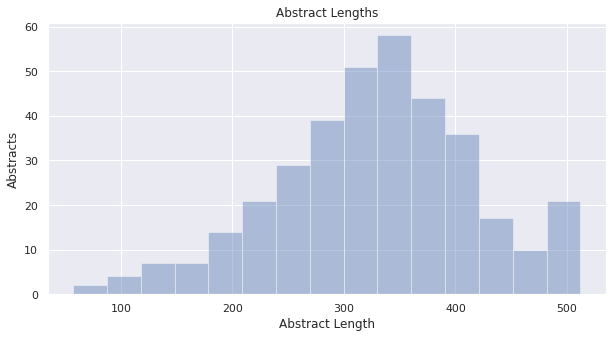

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

AUC 0.8607933442281979
MM Coef 0.6023471782885925
accuracy 0.8222222222222222
              precision    recall  f1-score   support

           0       0.66      0.80      0.73       106
           1       0.91      0.83      0.87       254

    accuracy                           0.82       360
   macro avg       0.79      0.82      0.80       360
weighted avg       0.84      0.82      0.83       360

Testing took 0:00:04


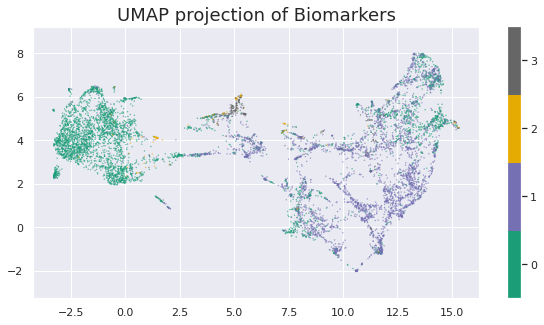

In [8]:
x = Pipeline("Biomarkers")
x.load_test_train("/content/drive/My Drive/bert_models/ridout_annotated.csv")
x.load_cancer_test("/content/drive/My Drive/bert_models/KR_annotated_filledin.csv")
x.process_test_train()
x.process_cancer()
x.train_test_split()
#x.train_model()
x.load_model("/content/drive/My Drive/bert_models/bertmodels/model_scibert_Biomarkers_4.bin")
x.model_test()
x.make_umap()  